[![DOI](https://zenodo.org/badge/940091341.svg)](https://doi.org/10.5281/zenodo.14939868) <a href="https://www.globh2e.org.au/"><img src="https://img.shields.io/badge/ARC:Funding%20number-IC200100023-blue.svg"/></a>

# **Environmental space definition for global hydrogen production**
<!-- **<div style="text-align: left; font-size: 19px;"> Environmental space definition for global hydrogen production**</div> -->

<div style="text-align: left; font-size: 16px;">Michaël Lejeune<sup>a,b</sup>, Sami Kara<sup>a,b</sup>, Michael Zwicky Hauschild<sup>c,d</sup>, Sareh Sharabifarahni<sup>a</sup>, Rahman Daiyan<sup>b,e</sup></div><br>

<div style="text-align: left; font-size: 13px;"><sup>a</sup>Sustainability in Manufacturing and Life Cycle Engineering Research Group, School of Mechanical and Manufacturing Engineering, the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>b</sup>Australian Research Council Training Centre for the Global Hydrogen Economy (GlobH2e), the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>c</sup>Centre for Absolute Sustainability, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>d</sup>Division for Quantitative Sustainability Assessment (QSA), Department of Environmental and Resource Engineering, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>e</sup>School of Minerals and Energy Engineering, The University of New South Wales, Sydney 2052, Australia</div><br>

<div style="text-align: left; font-size: 13px;"> Code developer and maintainer:<a href="mailto:m.lejeune@unsw.edu.au"> Michaël Lejeune</div></a><br>


# **0. Initialisation**

In [1]:
using CSV,DataFrames,XLSX,Statistics, Interpolations
using LinearAlgebra,SparseArrays
using JLD2
include("Utils/2_02_utils.jl");


Setting rcParams


/Users/mickael/anaconda3/envs/ab/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


["#f94144", "#f3722c", "#f8961e", "#f9844a", "#f9c74f", "#90be6d", "#43aa8b", "#4d908e", "#577590", "#277da1"]


In [2]:
AR6 = CSV.read("/Users/mickael/Library/CloudStorage/OneDrive-UNSW/Research/Code and data/AR6_data/World.csv/AR6_Scenarios_Database_World_v1.1.csv", DataFrame);

SSP1 = CSV.read(scenario_path*"SSP1-remind.csv", DataFrame) # REMIND SSP1-pkbudg500
SSP2 = CSV.read(scenario_path*"SSP2-remind.csv", DataFrame) # REMIND SSP2-pkbudg500
SSP5 = CSV.read(scenario_path*"SSP5-remind.csv", DataFrame) # REMIND SSP5-pkbudg500
SSP=vcat(SSP1, SSP2, SSP5);
years = parse.(Int, names(SSP)[findfirst(==("2020"), names(SSP)):findfirst(==("2100"), names(SSP))]);


# **1. Introduction**

In the previous [notebook](1_00_impact.ipynb), the total human impact.

# **2. Scenario selection**


Scenarios have to be selected according to their climate objectives by the end of the decade.

In [3]:
target=1.9
allowed_σ = 0.05 # 5% allowed deviation from the target
targetf=target*(1+allowed_σ)


1.9949999999999999

In [4]:
SSPa = filter(row -> !ismissing(row["2100"]) && row["2100"] <= targetf && row[:Variable] == "AR6 climate diagnostics|Effective Radiative Forcing|MAGICCv7.5.3|50.0th Percentile" && row[:Region] == "World", AR6);


accepted_mods=["REMIND","MESSAGEix-GLOBIOM","POLES","IMAGE","PROMETHEUS","TIAM","REmap","COFFEE","EPPA","McKinsey","GCAM","GMM"]
rejected_mods=["EMF33","CD-LINKS","SSP1-19","SSP2-19","SSP5-19"]


mask = Set((s[:Model], s[:Scenario]) for s in eachrow(SSPa) if any(mod -> occursin(mod, s[:Model]), accepted_mods) && all(mod -> !(occursin(mod, s[:Scenario]) && !(occursin("REMIND", s[:Model]) && occursin("CD-LINKS", s[:Scenario]))), rejected_mods))


AR6a = filter(row -> (row[:Model], row[:Scenario]) in mask, AR6) # filtering the original AR6 database
vars=unique(AR6a[!, :Variable]) ;# getting all the variables available in these models and scenarios


In [5]:
unique(AR6a[!, :Scenario])


15-element Vector{String}:
 "ADVANCE_2020_1.5C-2100"
 "ADVANCE_2030_1.5C-2100"
 "CEMICS-1.5-CDR12"
 "CEMICS-1.5-CDR20"
 "CEMICS_HotellingConst_1p5"
 "CD-LINKS_INDC2030i_400"
 "CD-LINKS_NPi2020_400"
 "PEP_1p5C_full_NDC"
 "PEP_1p5C_full_eff"
 "PEP_1p5C_full_goodpractice"
 "PEP_1p5C_red_eff"
 "SMP_1p5C_Def"
 "SMP_1p5C_Sust"
 "SMP_1p5C_lifesty"
 "SMP_1p5C_regul"

In [6]:
oo = []
for (mod, scn) in mask
    try
        add_missingr(mod, scn)
        push!(oo, mod => scn)
    catch e
        @warn "Skipping $(mod), $(scn): $(e.msg)"  
    end
end


In [7]:
oo


17-element Vector{Any}:
            "REMIND 2.1" => "CEMICS_HotellingConst_1p5"
            "REMIND 1.7" => "CEMICS-1.5-CDR20"
         "POLES ADVANCE" => "ADVANCE_2030_1.5C-2100"
 "REMIND-MAgPIE 1.7-3.0" => "PEP_1p5C_red_eff"
            "REMIND 1.7" => "ADVANCE_2030_1.5C-2100"
 "REMIND-MAgPIE 1.7-3.0" => "CD-LINKS_NPi2020_400"
            "REMIND 1.7" => "CEMICS-1.5-CDR12"
 "REMIND-MAgPIE 1.7-3.0" => "SMP_1p5C_Def"
 "REMIND-MAgPIE 1.7-3.0" => "SMP_1p5C_regul"
 "REMIND-MAgPIE 1.7-3.0" => "PEP_1p5C_full_NDC"
 "REMIND-MAgPIE 1.7-3.0" => "PEP_1p5C_full_goodpractice"
 "REMIND-MAgPIE 1.7-3.0" => "SMP_1p5C_Sust"
            "REMIND 1.7" => "ADVANCE_2020_1.5C-2100"
         "POLES ADVANCE" => "ADVANCE_2020_1.5C-2100"
 "REMIND-MAgPIE 1.7-3.0" => "PEP_1p5C_full_eff"
 "REMIND-MAgPIE 1.7-3.0" => "CD-LINKS_INDC2030i_400"
 "REMIND-MAgPIE 1.7-3.0" => "SMP_1p5C_lifesty"

After filtering the scenarios, we can look at what these scenarios would lead to

# **2. Estimating the allocation factor for hydrogen production**


## **2.1. economic allocation** 

In [26]:
lifetimes=[get_vals(i) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Lifetime"
                                "Tech|Hydrogen|Biomass|w/o CC|Lifetime"
                                "Tech|Hydrogen|Coal|w/ CC|Lifetime"
                                "Tech|Hydrogen|Coal|w/o CC|Lifetime"
                                "Tech|Hydrogen|Electricity|Lifetime"
                                "Tech|Hydrogen|Gas|w/ CC|Lifetime"
                                "Tech|Hydrogen|Gas|w/o CC|Lifetime"]] #yr

capex=[get_vals(i) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Biomass|w/o CC|Capital Costs"
                                "Tech|Hydrogen|Coal|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Coal|w/o CC|Capital Costs"
                                "Tech|Hydrogen|Electricity|Capital Costs"
                                "Tech|Hydrogen|Gas|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Gas|w/o CC|Capital Costs"]] #US$/kW

annual_capex=[i./j for (i,j) ∈ zip(capex,lifetimes)] #US$/kW/yr


capex_adj=[get_vals(i) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Biomass|w/o CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Coal|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Coal|w/o CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Electricity|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Gas|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Gas|w/o CC|Capital Costs|w/ Adj Costs"]]

annual_capex_adj=[i./j for (i,j) ∈ zip(capex_adj,lifetimes)] #US$/kW/yr

opex_fixed=[get_vals(i) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Biomass|w/o CC|OM Cost|fixed"
                                "Tech|Hydrogen|Coal|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Coal|w/o CC|OM Cost|fixed"
                                "Tech|Hydrogen|Electricity|OM Cost|fixed"
                                "Tech|Hydrogen|Gas|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Gas|w/o CC|OM Cost|fixed"]] #US$/kW/yr


opex_var=[get_vals(i).*31.536 for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Biomass|w/o CC|OM Cost|variable"
                                        "Tech|Hydrogen|Coal|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Coal|w/o CC|OM Cost|variable"
                                        "Tech|Hydrogen|Electricity|OM Cost|variable"
                                        "Tech|Hydrogen|Gas|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Gas|w/o CC|OM Cost|variable"]] #US$/kW/yr
;

total_costs= [a.+b.+c for (a,b,c) ∈ zip(annual_capex,opex_fixed,opex_var)] #US$/kW/yr

total_costs=total_costs[1].+total_costs[2].+total_costs[3].+total_costs[4].+total_costs[5].+total_costs[6].+total_costs[7]


Row,2020,2025,2030,2035,2040,2045,2050,2055,2060,2070,2080,2090,2100
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1367.43,1167.9,1019.53,937.227,930.382,924.415,919.722,916.394,914.22,913.201,927.582,922.744,914.846
2,1367.43,1162.73,1008.15,926.115,919.099,916.217,913.381,911.404,909.877,915.794,924.206,922.961,922.235
3,1367.43,1163.65,1007.08,925.49,918.482,915.315,912.407,909.877,907.963,905.44,920.347,919.225,918.521


In [27]:
GDP=get_vals("GDP|PPP")
shares_gdp= total_costs./GDP./TotalkgH2


Row,2020,2025,2030,2035,2040,2045,2050,2055,2060,2070,2080,2090,2100
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3.18451e-12,5.6597e-13,2.24799e-13,8.49014e-14,3.74916e-14,1.82443e-14,1.04935e-14,6.74192e-15,4.63178e-15,3.53884e-15,3.14366e-15,2.9575e-15,2.59704e-15
2,3.18451e-12,5.17821e-13,1.50495e-13,4.82045e-14,2.19683e-14,1.2778e-14,8.17796e-15,5.55529e-15,3.70472e-15,2.49135e-15,1.86765e-15,1.40966e-15,1.03147e-15
3,3.18451e-12,4.89216e-13,1.07463e-13,2.75932e-14,1.00799e-14,4.57193e-15,2.24233e-15,1.21573e-15,6.7873e-16,3.79117e-16,2.45673e-16,1.73436e-16,1.3577e-16


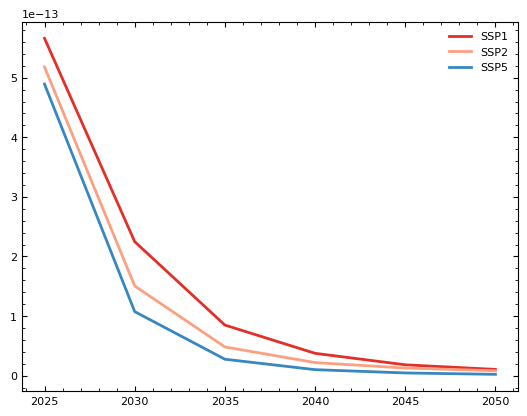

In [28]:
plt.plot(2025:5:2050,Matrix(shares_gdp)[:,2:7]',label=["SSP1","SSP2", "SSP5"],linewidth=2)
plt.legend(frameon=false)
display(plt.gcf())
plt.close("all")


## **2.2. Emission based allocation** 

In [29]:
sn=1:3 # selecting the scenarios to plot
yr=2:7 # 2025 to 2050 # 2:9 for 2060

Emi_gross_pkbudg500=get_vals("Emi|CO2|Gross")[sn,1:9]|>Matrix
Emi_pkbudg500=get_vals("Emi|CO2")[sn,1:9]|>Matrix
EmiSE_pkbudg500=get_vals("Emi|CO2|Gross|Energy|+|Supply")[sn,1:9]|>Matrix
SE_pkbudg500=get_vals("SE")[sn,1:9]|>Matrix
SEH2_pkbudg500=get_vals("SE|Hydrogen")[1:3,1:9]|>Matrix
;


Emi=interpolate_data(get_vals("Emissions|CO2",SSP=AR6a))
Emi=vcat(Emi,Emi_pkbudg500)#|> highres # add the pkbudg500 values and interpolate data to 1 year resolution
cumEmi=cumsum(Emi,dims=2).*1e-3 # cummulative sum of emissions in GtCO2
# #--
Emi_gross=interpolate_data(get_vals("Emissions|CO2|Gross",SSP=AR6a))
Emi_gross=vcat(Emi_gross,Emi_gross_pkbudg500)#|> highres
# #--
cumEmi_gross=cumsum(Emi_gross,dims=2).*1e-3
EmiSE=interpolate_data(get_vals("Emissions|CO2|Gross|Energy|Supply",SSP=AR6a))
EmiSE=vcat(EmiSE,EmiSE_pkbudg500)#|> highres
#--
SE=interpolate_data(get_vals("Secondary Energy",SSP=AR6a))
SE=vcat(SE,SE_pkbudg500)#|> highres
#--
SEH2=interpolate_data(get_vals("Secondary Energy|Hydrogen",SSP=AR6a))
SEH2=vcat(SEH2,SEH2_pkbudg500)#|> highres
;

kgH2=SEH2.*EJH2_to_kgH2 # mass H2
MtH2=kgH2.*1e-9 # mass H2 to Mt H2
GtH2=kgH2.*1e-12 # mass H2 to Gt H2

AP=((EmiSE./Emi_gross).*(SEH2./SE))[:,yr]
SAP=(AP./kgH2[:,yr])
;


In [31]:
TotalkgH2=get_vals("SE|Hydrogen").*EJH2_to_kgH2
α¹ =Matrix((get_vals("Emi|CO2|Gross|Energy|Supply|+|Hydrogen")./get_vals("Emi|CO2|Gross"))./TotalkgH2)'


13×3 adjoint(::Matrix{Float64}) with eltype Float64:
 2.24634e-13  2.24634e-13  2.24634e-13
 2.00513e-13  1.91272e-13  1.81933e-13
 1.85703e-13  1.13066e-13  8.51159e-14
 7.79064e-14  3.11059e-14  1.72219e-14
 3.85044e-15  4.21188e-16  3.03283e-16
 1.09679e-15  4.28076e-16  2.19822e-16
 1.01862e-15  4.3233e-16   1.57968e-16
 9.85226e-16  4.04065e-16  1.33076e-16
 8.40754e-16  2.94032e-16  9.44155e-17
 4.19577e-16  6.74951e-17  3.1754e-17
 3.35214e-17  6.38409e-19  7.96709e-20
 1.20702e-18  4.67293e-19  6.20936e-20
 7.20519e-19  2.68028e-19  3.43863e-20

## **2.3. utilitarian principle** 

In [32]:
share=get_vals("SE|Hydrogen")./get_vals("SE")
α² =Matrix(((get_vals("Emi|CO2|Gross|Energy|+|Supply")./get_vals("Emi|CO2|Gross")).*share)./TotalkgH2)';


## Comparison of allocation factors

In this section, we use the results derived from the analysis in the [AR6.ipynb](AR6.ipynb) notebook. 

In [33]:
mins = mapslices(x -> minimum(x), SAP; dims=1)|>vec
maxs = mapslices(x -> maximum(x), SAP; dims=1)|>vec

q_5 = mapslices(x -> quantile(x, 0.05), SAP; dims=1)|>vec
q_25 = mapslices(x -> quantile(x, 0.25), SAP; dims=1)|>vec
q_50 = median(SAP, dims=1)|>vec
q_75 = mapslices(x -> quantile(x, 0.75), SAP; dims=1)|>vec;
q_95 = mapslices(x -> quantile(x, 0.95), SAP; dims=1)|>vec


6-element Vector{Float64}:
 9.639416483910631e-14
 9.161478097030568e-14
 8.822138280671028e-14
 8.943786066496047e-14
 1.0796007006426142e-13
 1.1816351559322156e-13

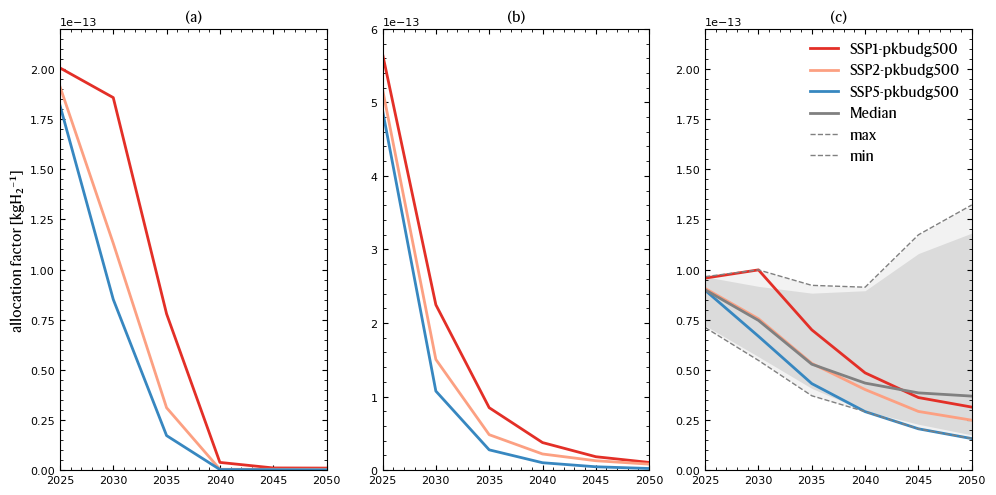

In [34]:
rcParams["axes.prop_cycle"] = plt.cycler("color",["#e32f27"
                                                "#fca082"
                                                "#3787c0"]);
                                                
fig, axs = plt.subplots(1,3,figsize=(10,5))#,figsize=(12,7),sharey=true
axs[1].plot(2025:5:2050,α¹'[1:3,2:7]' ,label=["SSP1-pkbudg500","SSP2-pkbudg500", "SSP5-pkbudg500"],linewidth=2)
axs[3].plot(2025:5:2050,α²'[1:3,2:7]',label=["SSP1-pkbudg500","SSP2-pkbudg500", "SSP5-pkbudg500"],linewidth=2)
axs[3].plot(2025:5:2050,q_50 ,label="Median",linewidth=2, color="grey")
axs[2].plot(2025:5:2050,Matrix(shares_gdp)[:,2:7]',label=["SSP1-pkbudg500","SSP2-pkbudg500", "SSP5-pkbudg500"],linewidth=2)

axs[3].plot(2025:5:2050,maxs ,label="max",linewidth=1, linestyle="--", color="grey")
axs[3].plot(2025:5:2050,mins ,label="min",linewidth=1, linestyle="--", color="grey")

axs[3].fill_between(x=2025:5:2050, y1=mins, y2=maxs, color="grey",linewidth=0, alpha=0.1)
axs[3].fill_between(x=2025:5:2050, y1=q_5, y2=q_95, color="grey",linewidth=0, alpha=0.2)
# axs[2].fill_between(x=2025:5:2050, y1=q_25, y2=q_75, color="grey",linewidth=0, alpha=0.3)

axs[1].set_ylim(0, 2.2e-13)
axs[3].set_ylim(0, 2.2e-13)
axs[2].set_ylim(0, 6e-13)
axs[1].set_xlim(2025, 2050)
axs[2].set_xlim(2025, 2050)
axs[3].set_xlim(2025, 2050)

axs[1].set_ylabel("allocation factor [kgH₂⁻¹]",fontproperties=font_prop_labels)
# ax.figure.set_facecolor("white")

axs[1].set_title("(a)",fontproperties=font_prop_labels)
axs[2].set_title("(b)",fontproperties=font_prop_labels)
axs[3].set_title("(c)",fontproperties=font_prop_labels)


plt.tight_layout()
plt.legend(frameon=false,prop=font_prop_labels)
plt.savefig(respath*"/SI_Fig3.svg",transparent=true)
plt.savefig(respath*"/SI_Fig3.png",dpi=800,transparent=true)
display(plt.gcf())
plt.close("all")


In [16]:
@save respath*"allocation_factors.jld" SAP AP


## Plotting utilitarian allocation factors

Next, we want to increase the interpolation to go from 5 years to 1 year step so cummulative emissions would render properly. We will simply use the `highres` function available in the supplementary variables. To avoid overcomplicating, we will just repeat what we did before with that function. 

In [17]:
Emi_hr=interpolate_data(get_vals("Emissions|CO2",SSP=AR6a))
Emi_hr=vcat(Emi_hr,Emi_pkbudg500)|> highres # add the pkbudg500 values and interpolate data to 1 year resolution
cumEmi_hr=cumsum(Emi_hr,dims=2).*1e-3 # cummulative sum of emissions in GtCO2
#--
Emi_gross_hr=interpolate_data(get_vals("Emissions|CO2|Gross",SSP=AR6a))
Emi_gross_hr=vcat(Emi_gross_hr,Emi_gross_pkbudg500)|> highres
#--
cumEmi_gross_hr=cumsum(Emi_gross,dims=2).*1e-3
EmiSE_hr=interpolate_data(get_vals("Emissions|CO2|Gross|Energy|Supply",SSP=AR6a))
EmiSE_hr=vcat(EmiSE_hr,EmiSE_pkbudg500)|> highres
#--
SE_hr=interpolate_data(get_vals("Secondary Energy",SSP=AR6a))
SE_hr=vcat(SE_hr,SE_pkbudg500)|> highres
#--
SEH2_hr=interpolate_data(get_vals("Secondary Energy|Hydrogen",SSP=AR6a))
SEH2_hr=vcat(SEH2_hr,SEH2_pkbudg500)|> highres

#--
kgH2_hr=SEH2_hr.*EJH2_to_kgH2 # mass H2
MtH2_hr=kgH2_hr.*1e-9 # mass H2 to Mt H2
GtH2_hr=kgH2_hr.*1e-12 # mass H2 to Gt H2

MtH2_pkbudg_hr=(highres(SEH2_pkbudg500).*EJH2_to_kgH2.*1e-9)[1:3,:]
#--
cummH2_hr=cumsum(GtH2_hr,dims=2)
Emi_gross_pkbudg500_hr=highres(Emi_gross_pkbudg500)[1:3,:]
cumEmi_gross_pkbudg500_hr=cumsum(Emi_gross_pkbudg500_hr,dims=2).*1e-3
Emi_pkbudg500_hr=highres(Emi_pkbudg500)[1:3,:]
cumEmi_pkbudg500_hr=cumsum(Emi_pkbudg500_hr,dims=2).*1e-3

#-- allocation principle
AP_hr=(EmiSE_hr./Emi_gross_hr).*(SEH2_hr./SE_hr)
AP_pkbudg500_hr=(EmiSE_pkbudg500./Emi_gross_pkbudg500).*(SEH2_pkbudg500./SE_pkbudg500)|> highres
AP_pkbudg500_hr=AP_pkbudg500_hr[1:3,:]
SAP_hr=AP_hr./kgH2_hr;

kgH2_pkbudg500=SEH2_pkbudg500.*EJH2_to_kgH2|> highres # mass H2
SAP_pkbudg500_hr=AP_pkbudg500_hr./kgH2_pkbudg500[1:3,:];


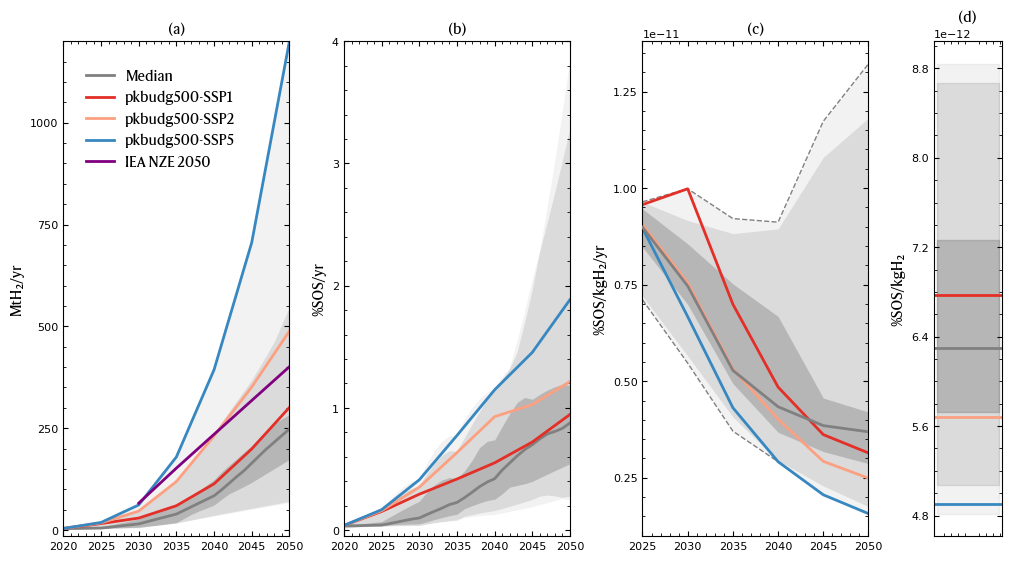

In [18]:
A,B,C,D = plt.figure(figsize=(10, 5.5),facecolor="none",layout="constrained").subplot_mosaic(
                                        "ABCD",
                                        width_ratios=[1,1,1,0.3])
                                        axs=[B,A,C,D]
                                        axs=[i[2] for i in axs]

for (ax,mat,l) in  zip(axs[1:2],[MtH2_hr,AP_hr.*100],["Median","Median"])
    mins_hr = minimum(mat, dims=1)|>vec
    maxs_hr= maximum(mat, dims=1)|>vec
    q05_hr = mapslices(x -> quantile(x, 0.05), mat; dims=1)|>vec
    q25_hr = mapslices(x -> quantile(x, 0.25), mat; dims=1)|>vec
    q50_hr = mapslices(x -> median(x), mat; dims=1)|>vec
    q75_hr = mapslices(x -> quantile(x, 0.75), mat; dims=1)|>vec
    q95_hr = mapslices(x -> quantile(x, 0.95), mat; dims=1)|>vec
    ax.plot(collect(2020:1:2060), q50_hr,color="grey",label=l,lw=2)
    ax.fill_between(x=collect(2020:1:2060), y1=mins_hr, y2=maxs_hr, color="grey",linewidth=0, alpha=0.1)
    ax.fill_between(x=collect(2020:1:2060), y1=q05_hr, y2=q95_hr, color="grey",linewidth=0, alpha=0.2)
    ax.fill_between(x=collect(2020:1:2060), y1=q25_hr, y2=q75_hr, color="grey",linewidth=0, alpha=0.4)
    ax.set_ylabel(l, fontproperties=font_prop)
    ax.tick_params(axis="both", direction="in")
end

for (i,k,l) in zip(1:3,["yellow","orange","purple"],["pkbudg500-SSP1","pkbudg500-SSP2","pkbudg500-SSP5"])
    axs[1].plot(collect(2020:1:2050),(MtH2_pkbudg_hr[:,1:end-10][i,:])',linestyle="-",lw=2,label=l)
end

IEA_years=[2030, 2035, 2050]
IEA_vals=[66, 152, 401]#.*EJH2_to_kgH2*1.e-9
axs[1].plot(IEA_years,IEA_vals,label="IEA NZE 2050",color="purple",linestyle="-",lw=2)
axs[1].set_xlim(2020, 2050)
axs[1].set_ylabel("MtH₂/yr", fontproperties=font_prop)
axs[1].set_ylim(-15, 1200)
axs[1].set_title("(a)", fontproperties=font_prop)

for (i,k) in zip(1:3,["yellow","orange","purple"])
    axs[2].plot(collect(2020:1:2050),(AP_pkbudg500_hr[:,1:end-10][i,:]).*100',linestyle="-",lw=2)
end

axs[2].set_xlim(2020, 2050)
axs[2].set_ylabel("%SOS/yr", fontproperties=font_prop)
axs[2].set_ylim(-0.0005.*100, 0.04.*100)
axs[2].set_title("(b)", fontproperties=font_prop)


## Plotting the space per kg of H₂
mins = mapslices(x -> minimum(x), SAP; dims=1).*100|>vec
maxs = mapslices(x -> maximum(x), SAP; dims=1).*100|>vec
q_5 = mapslices(x -> quantile(x, 0.05), SAP; dims=1).*100|>vec
q_25 = mapslices(x -> quantile(x, 0.25), SAP; dims=1).*100|>vec
q_50 = median(SAP, dims=1).*100|>vec
q_75 = mapslices(x -> quantile(x, 0.75), SAP; dims=1).*100|>vec;
q_95 = mapslices(x -> quantile(x, 0.95), SAP; dims=1).*100|>vec
axs[3].plot(2025:5:2050,q_50 ,label="Median",linewidth=2, color="grey",zorder=3)
axs[3].plot(2025:5:2050,maxs ,label="max",linewidth=1, linestyle="--", color="grey")
axs[3].plot(2025:5:2050,mins ,label="min",linewidth=1, linestyle="--", color="grey")
axs[3].fill_between(x=2025:5:2050, y1=mins, y2=maxs, color="grey",linewidth=0, alpha=0.1)
axs[3].fill_between(x=2025:5:2050, y1=q_5, y2=q_95, color="grey",linewidth=0, alpha=0.2)
axs[3].fill_between(x=2025:5:2050, y1=q_25, y2=q_75, color="grey",linewidth=0, alpha=0.4)
axs[3].plot(2025:5:2050,α²'[1:3,2:7]'.*100,label=["SSP1-pkbudg500","SSP2-pkbudg500", "SSP5-pkbudg500"],linewidth=2)
axs[3].set_xlim(2025, 2050)
axs[3].set_ylabel("%SOS/kgH₂/yr", fontproperties=font_prop)
axs[3].set_title("(c)", fontproperties=font_prop)


## Static space 
vect=mean(SAP_hr[:,1:end-10],dims=2)
minvect_hr=minimum(vect)*100
maxvect_hr=maximum(vect)*100
q50_hr=median(vect)*100
q05_hr = mapslices(x -> quantile(x, 0.05), vect; dims=1)*100
q25_hr = mapslices(x -> quantile(x, 0.25), vect; dims=1)*100
q75_hr = mapslices(x -> quantile(x, 0.75), vect; dims=1)*100
q95_hr= mapslices(x -> quantile(x, 0.95), vect; dims=1)*100
axs[4].axhline([q50_hr],color="grey",linestyle="-", xmin=0, xmax=1,lw=2)
axs[4].fill_between(x=[0, maxvect_hr], y1=minvect_hr, y2=maxvect_hr, color="grey", alpha=0.1)
axs[4].tick_params(bottom=false, labelbottom=false)
axs[4].fill_between(x=[0, maxvect_hr], y1=q05_hr[1], y2=q95_hr[1], color="grey", alpha=0.2)
axs[4].fill_between(x=[0, maxvect_hr], y1=q25_hr[1], y2=q75_hr[1], color="grey", alpha=0.4)
axs[4].set_ylabel("%SOS/kgH₂", fontproperties=font_prop)
axs[4].set_title("(d)", fontproperties=font_prop)
axs[4].tick_params(axis="both", top=false, bottom=false)

for (i,k) in zip(1:3,["#e32f27","#fca082","#3787c0"])
    vect=mean(SAP_pkbudg500_hr[:,1:end-10][i,:]',dims=2)*100
    axs[4].axhline([vect],color=k,linestyle="-", xmin=0, xmax=1,lw=2)
end

axs[1].yaxis.set_major_locator(tkr.MaxNLocator(integer=true, nbins=5))
axs[2].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=5))
axs[3].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=6))
axs[4].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=6))
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels, frameon=false, loc="upper center", bbox_to_anchor=(0.43, 0.97), ncol=1, prop=font_prop)
plt.savefig(respath*"summary_res.svg", bbox_inches="tight",transparent=true)
plt.savefig(respath*"summary_res.png", dpi=800,bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


# **3. Allocated safe operating space**

First we load the safe operating space.

In [19]:
# sos=load("../results/2_01_global_space/data_SOS.jld2")


Now we can unpack variables 

In [20]:
# 𝚫𝐗ᴾᵇ,𝚫𝐗ᴰ,units,catnames=sos["𝚫𝐗ᴾᵇ"],sos["𝚫𝐗ᴰ"],sos["units"],sos["control_var"];


$$
\boldsymbol{\omega^{b}} = \alpha \times \boldsymbol{\Delta X^{b}} \quad \forall b \in \left\{PB, D \right\}
\tag{3}
$$


When this is done, we need to broadcast these vectors into matrices to fit the dimensions of our study. We have 3 scenarios and 6 years. To respect the convention used in this work

$$
\boldsymbol{\Omega^{b}_{yq} = \alpha_{yq} \times \Delta X^{b}}  \quad \forall b \in \left\{PB, D \right\}
\tag{3}
$$

In [21]:
# 𝚨min =ones(3,6).*mins'
# 𝚨05=ones(3,6).*q_5'
# 𝚨25=ones(3,6).*q_25'
# 𝚨50=ones(3,6).*q_50'
# 𝚨75=ones(3,6).*q_75'
# 𝚨95=ones(3,6).*q_95'
# 𝚨max=ones(3,6).*maxs'


In [22]:
# 𝛀ᴾᵇ05=[𝚫𝐗ᴾᵇ*α for α in 𝚨05]'|>Matrix
# 𝛀ᴰ05=[𝚫𝐗ᴰ*α for α in 𝚨05]'|>Matrix

# 𝛀ᴾᵇ50=[𝚫𝐗ᴾᵇ*α for α in 𝚨50]'|>Matrix
# 𝛀ᴰ50=[𝚫𝐗ᴰ*α for α in 𝚨50]'|>Matrix

# 𝛀ᴾᵇ95=[𝚫𝐗ᴾᵇ*α for α in 𝚨95]'|>Matrix
# 𝛀ᴰ95=[𝚫𝐗ᴰ*α for α in 𝚨95]'|>Matrix


In [23]:
# @save respath*"aSOS.jld" 𝛀ᴾᵇ05 𝛀ᴾᵇ50 𝛀ᴾᵇ95 𝛀ᴰ05 𝛀ᴰ50 𝛀ᴰ95


# **4. Climate change scenario variables**

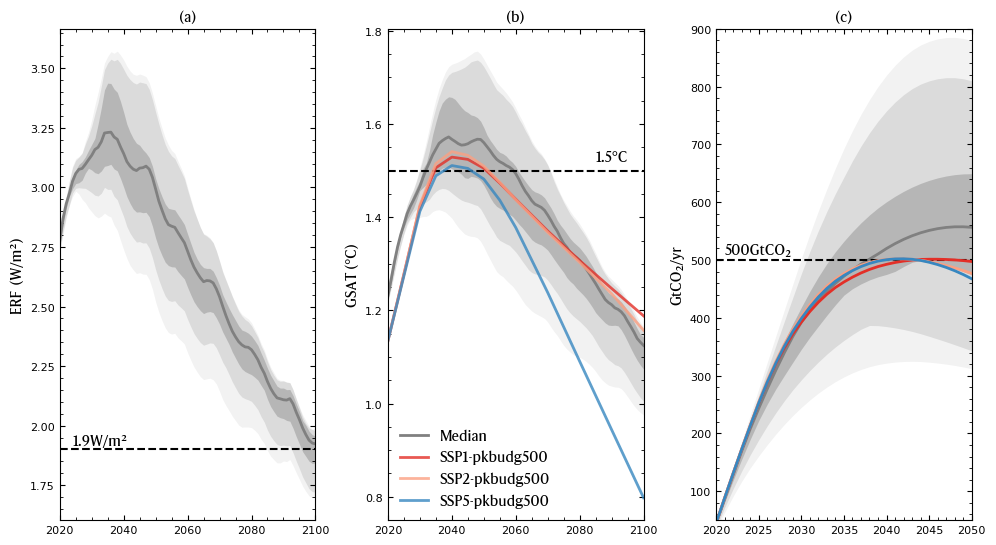

In [24]:
GSTA=get_vals("AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",SSP=AR6a)|>Matrix
RF=get_vals("AR6 climate diagnostics|Effective Radiative Forcing|MAGICCv7.5.3|50.0th Percentile",SSP=AR6a)|>Matrix;

fig, axs = plt.subplots(1, 3,figsize=(10, 5.5))#1, 2, figsize=(10, 5.5)
scn_varmo=get_vals("Temperature|Global Mean")|>Matrix
yrs_varmo=parse.(Int,names(get_vals("Temperature|Global Mean")))

for (ax,mat,l) in  zip(axs,[RF,GSTA],[nothing,"Median"])
    mins = minimum(mat, dims=1)|>vec
    maxs= maximum(mat, dims=1)|>vec
    q05 = mapslices(x -> quantile(x, 0.05), mat; dims=1)|>vec
    q25 = mapslices(x -> quantile(x, 0.25), mat; dims=1)|>vec
    q50 = mapslices(x -> median(x), mat; dims=1)|>vec
    q75 = mapslices(x -> quantile(x, 0.75), mat; dims=1)|>vec
    q95 = mapslices(x -> quantile(x, 0.95), mat; dims=1)|>vec
    
    ax.plot(collect(2020:1:2100), q50,color="grey",label=l,lw=2)
    ax.fill_between(x=collect(2020:1:2100), y1=mins, y2=maxs, color="grey",linewidth=0, alpha=0.1)
    ax.fill_between(x=collect(2020:1:2100), y1=q05, y2=q95, color="grey",linewidth=0, alpha=0.2)
    ax.fill_between(x=collect(2020:1:2100), y1=q25, y2=q75, color="grey",linewidth=0, alpha=0.4)
    ax.set_ylabel(l, fontproperties=font_prop)
    ax.tick_params(axis="both", direction="in")
end


axs[3].plot(collect(2020:1:2060), median(cumEmi_hr, dims=1)|>vec, color="grey", label="Median", lw=2)
axs[3].fill_between(x=collect(2020:1:2060), y1=minimum(cumEmi_hr, dims=1)|>vec, y2=maximum(cumEmi_hr, dims=1)|>vec, color="grey", linewidth=0, alpha=0.1)
axs[3].fill_between(x=collect(2020:1:2060), y1=mapslices(x -> quantile(x, 0.05), cumEmi_hr; dims=1)|>vec, y2=mapslices(x -> quantile(x, 0.95), cumEmi_hr; dims=1)|>vec, color="grey", linewidth=0, alpha=0.2)
axs[3].fill_between(x=collect(2020:1:2060), y1=mapslices(x -> quantile(x, 0.25), cumEmi_hr; dims=1)|>vec, y2=mapslices(x -> quantile(x, 0.75), cumEmi_hr; dims=1)|>vec, color="grey", linewidth=0, alpha=0.4)
axs[3].set_ylim(50, 900)
axs[3].set_xlim(2020, 2050)
axs[3].axhline([500],color="black",linestyle="--",xmax=1)
for (i,k,l) in zip(1:3,["yellow","orange","purple"],["pkbudg500-SSP1","pkbudg500-SSP2","pkbudg500-SSP5"])
    axs[3].plot(collect(2020:1:2050),(cumEmi_pkbudg500_hr[:,1:end-10][i,:])',linestyle="-",label=l,lw=2)
end
axs[3].annotate("500GtCO₂", xy=(2021, 510), xytext=(2021, 510), fontsize=10, fontproperties=font_prop)
axs[3].set_ylabel("GtCO₂/yr", fontproperties=font_prop)
axs[3].set_title("(c)", fontproperties=font_prop)


axs[1].axhline([1.9],color="black",linestyle="--",xmax=1)
axs[2].axhline([1.5],color="black",linestyle="--",xmax=1)
axs[1].annotate("1.9W/m²", xy=(2024, 1.92), xytext=(2024, 1.92), fontsize=10, fontproperties=font_prop)
axs[2].annotate("1.5°C", xy=(2085, 1.52), xytext=(2085, 1.52), fontsize=10, fontproperties=font_prop)
axs[2].plot(yrs_varmo, scn_varmo',label=["SSP1-pkbudg500","SSP2-pkbudg500", "SSP5-pkbudg500"],lw=2,linestyle="-",alpha=0.8)
axs[2].legend(frameon=false, loc= "lower left", prop=font_prop)
# axs[1].legend(frameon=false, prop=font_prop)
axs[1].set_ylabel("ERF  (W/m²)", fontproperties=font_prop)
axs[2].set_ylabel("GSAT (°C)", fontproperties=font_prop)
axs[1].set_xlim(2020, 2100)
axs[2].set_xlim(2020, 2100)
axs[1].set_title("(a)", fontproperties=font_prop)
axs[2].set_title("(b)", fontproperties=font_prop)

fig.tight_layout()

display(plt.gcf())
fig.savefig(respath*"climate_vars.svg", bbox_inches="tight",transparent=true)
fig.savefig(respath*"climate_vars.png", dpi=800 ,bbox_inches="tight",transparent=true)
plt.close("all")
